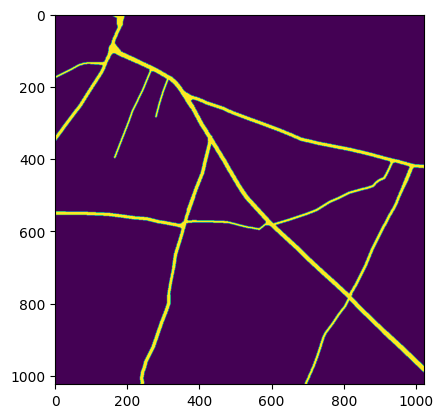

In [101]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from skimage.filters import sobel

img_name = ""
img_folder = ""
filename = f'{img_folder}\{img_folder}_sat.jpg'
correct_mask = '{img_folder}\{img_name}_mask.png'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
cmask= cv2.imread(correct_mask, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.imshow(cmask)

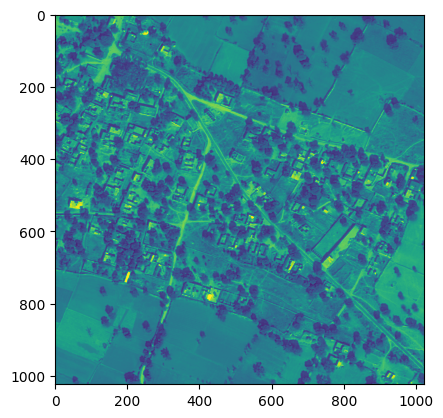

In [102]:
plt.imshow(img)

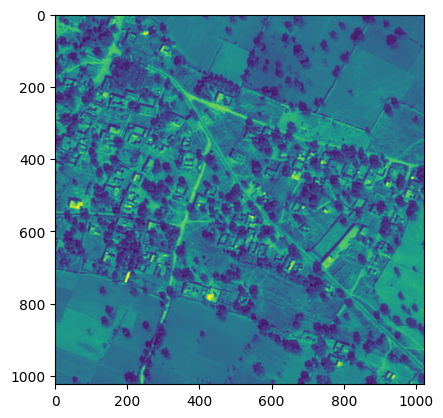

In [103]:

filtered = cv2.bilateralFilter(img, 5, 7500e3, 7500e3)
plt.imshow(filtered)

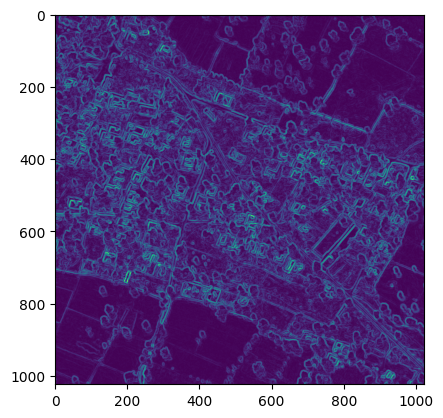

In [104]:

edge_sobel = sobel(filtered)
plt.imshow(edge_sobel)

In [105]:
import pywt
edge_sobel = filtered
coeffs2 = pywt.dwt2(edge_sobel, 'db1', 'zero', (1, 0))
LL, (LH, HL, HH) = coeffs2 

In [106]:
i =  cv2.bitwise_and(LL,HL+ LH)


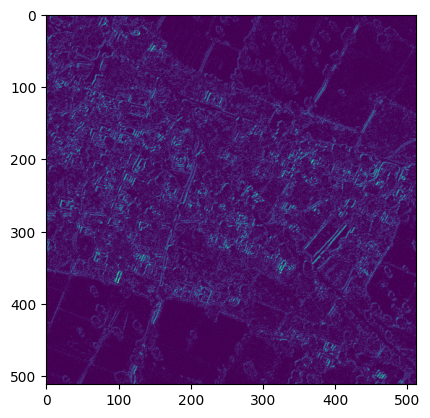

In [107]:
plt.imshow(i)

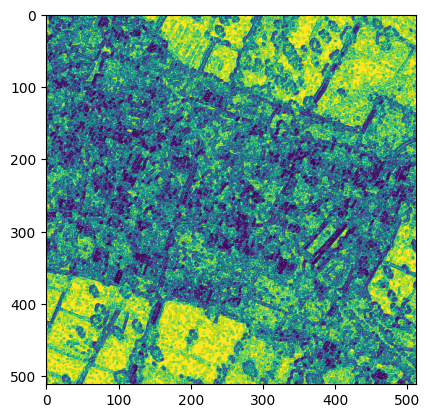

In [108]:
edge_sobel = sobel(i)
edge_sobel = cv2.normalize(edge_sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# print(edge_sobel.min())
equalized_img = 255 - cv2.equalizeHist(edge_sobel)
plt.imshow(equalized_img)

(array([[433.,  42.,  30., ...,   0.,   0.,   0.],
        [439.,  46.,  23., ...,   0.,   0.,   0.],
        [435.,  48.,  24., ...,   0.,   0.,   0.],
        ...,
        [490.,  20.,   2., ...,   0.,   0.,   0.],
        [491.,  20.,   1., ...,   0.,   0.,   0.],
        [493.,  15.,   4., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 512 BarContainer objects>)

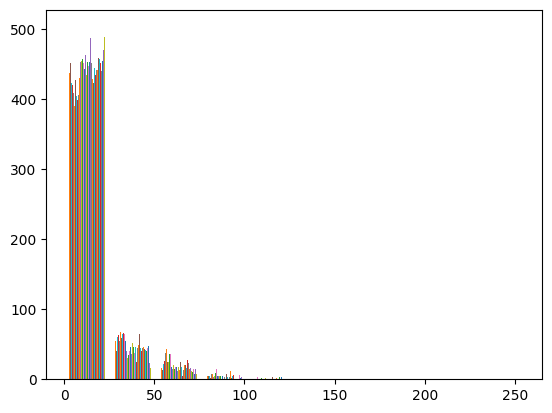

In [73]:
plt.hist(edge_sobel)

In [74]:
edges = cv2.Canny(edge_sobel,0,50)

In [76]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
dilated_edges = cv2.dilate(edges, kernel)

# Apply the dilated edges to the original image to extract the road features
# dilated_edges = cv2.threshold(edge_sobel,0,50)
road_features = cv2.bitwise_and(edge_sobel, dilated_edges)
blur = cv2.GaussianBlur(road_features, (1, 1), 3)

# Calculate the unsharp mask image
unsharp = cv2.addWeighted(road_features, 2.5, blur, -1, -5)

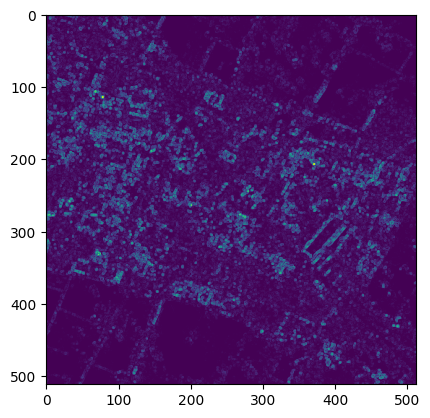

In [77]:
plt.imshow(unsharp)

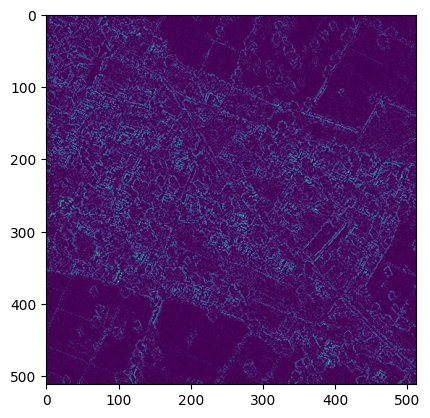

In [78]:

# Load the satellite image
img = cv2.imread(filename, 0)

# Apply the Sobel filter to the image to extract horizontal and vertical edges

# Apply the wavelet transform to the image to extract low and high frequency components
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs

sobelx = cv2.Sobel(LL, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(LL, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude and direction of the edges
magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
direction = np.arctan2(sobely, sobelx)
# Create a binary mask based on the high frequency components
HH_filt = cv2.GaussianBlur(HH, (3,3), 0)
HH_filt =  cv2.normalize(HH_filt, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, mask = cv2.threshold(HH_filt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Combine the edge and wavelet features using the binary mask
edge_features =  mask * magnitude
wavelet_features = LL * (1 - mask)
road_features = edge_features + wavelet_features

# Save the resulting road features image
plt.imshow(road_features)